<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Fixed-Parameters" data-toc-modified-id="Fixed-Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fixed Parameters</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimization</a></span><ul class="toc-item"><li><span><a href="#No-HC-Charging" data-toc-modified-id="No-HC-Charging-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>No HC Charging</a></span></li><li><span><a href="#HC-Charging" data-toc-modified-id="HC-Charging-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>HC Charging</a></span></li></ul></li></ul></div>

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product
from datetime import datetime

In [2]:
DEBUG = True

### Code

In [3]:
def load_and_prepare_data(
    import_file,
    columns_map):
    
    df = pd.read_csv(import_file)

    # First, reverse the columns_map dictionary to map old names to new names
    reverse_columns_map = {v: k for k, v in columns_map.items()}

    # Now rename the columns using the reversed mapping
    df = df.rename(columns=reverse_columns_map)

    # Set Index
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%m/%d/%Y %H:%M')

    # Set the datetime column as the index
    df.set_index('time_stamp', inplace=True)

    # Ensure the index is sorted chronologically
    df.sort_index(inplace=True)
    
    return df

In [77]:
def rescale_solar_production(
    df_original,
    original_capacity,
    new_capacity):
    
    """
    Rescale solar production data from original PV capacity to new PV capacity.

    Assumptions:
    1. Solar production scales linearly with panel capacity
    2. Consumption remains the same
    3. Export is increased production minus any additional self-consumption
    4. Import is reduced by any additional self-consumption

    Parameters:
    df_original (pd.DataFrame): Original DataFrame with energy data
    original_capacity (float): Original solar capacity in kWc
    new_capacity (float): New solar capacity in kWc

    Returns:
    pd.DataFrame: New DataFrame with rescaled values
    """
    
    if original_capacity == new_capacity:
        return df_original.copy()
    
    # Make a copy of the original dataframe to avoid modifying it
    df = df_original.copy()

    # Calculate scaling factor
    scaling_factor = new_capacity / original_capacity

    # Rescale produced_wh (solar production scales directly with panel capacity)
    df['produced_wh'] = df['produced_wh'] * scaling_factor

    # Calculate how much additional energy is now produced
    additional_production = df['produced_wh'] - df_original['produced_wh']

    # Calculate how much of this additional production can be self-consumed
    # This is the minimum between additional production and what would have been imported
    potential_self_consumption = df_original['imported_wh']
    additional_self_consumption = np.minimum(additional_production, potential_self_consumption)

    # Calculate new values for imported_wh and exported_wh
    # Imported energy decreases by the additional self-consumption
    df['imported_wh'] = df_original['imported_wh'] - additional_self_consumption
    df['imported_wh'] = df['imported_wh'].clip(lower=0)  # Can't have negative imports

    # Exported energy is original export plus any additional production not self-consumed
    df['exported_wh'] = df_original['exported_wh'] + (additional_production - additional_self_consumption)

    # Consumed energy stays the same (assumption in the problem statement)
    # But let's verify that energy balance still makes sense
    # Total energy available = produced + imported (from grid)
    # Total energy used = consumed + exported (to grid)
    # The difference between these should be zero

    # Return the rescaled dataframe
    return df

In [92]:
def simulate_battery(
    df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    max_battery_capacity_wh,
    battery_discharge_lower_limit_pc=10,
    battery_charge_upper_limit_pc=90,
    battery_efficiency_pc=95,
    max_battery_charge_rate_w=None,
    max_battery_discharge_rate_w=None,
    enable_hc_charging=True,
):
    """
    Simulate the addition of a battery to the solar panel system with updated charge/discharge logic and battery efficiency.

    Parameters:
    - df: pandas DataFrame with columns produced_wh, consumed_wh, exported_wh, imported_wh, and time_stamp as the index.
    - max_battery_capacity_wh: Maximum capacity of the battery in Wh.
    - wh_price_sale_eur: Price at which excess energy is sold back to the grid (€/Wh).
    - wh_price_high_eur: Price of energy during high-price periods (€/Wh).
    - wh_price_low_eur: Price of energy during low-price periods (€/Wh).
    - subscription_monthly_fee_eur: Fixed monthly subscription fee (€).
    - battery_discharge_lower_limit_pc: Minimum SOC percentage (0-25).
    - battery_charge_upper_limit_pc: Maximum SOC percentage (75-100).
    - battery_efficiency_pc: Battery round-trip efficiency percentage (0-100).
    - enable_hc_charging: Boolean flag to enable/disable battery charging from grid during HC periods.

    Returns:
    - total_cost_no_solar: Total annual cost without solar panels (€).
    - total_cost_with_solar: Total annual cost with solar panels but no battery (€).
    - total_cost_with_solar_battery: Cost with solar and battery, with grid recharging during HC controlled by enable_hc_charging flag.
    - df_with_battery: DataFrame with additional columns for battery operations and costs.
    """
    # Validate new parameters
    if not (0 <= battery_discharge_lower_limit_pc <= 25):
        raise ValueError("battery_discharge_lower_limit_pc must be between 0 and 25")
    if not (75 <= battery_charge_upper_limit_pc <= 100):
        raise ValueError("battery_charge_upper_limit_pc must be between 75 and 100")
    if not (0 <= battery_efficiency_pc <= 100):
        raise ValueError("battery_efficiency_pc must be between 0 and 100")

    # Calculate battery limits in Wh
    battery_discharge_lower_limit_wh = max_battery_capacity_wh * battery_discharge_lower_limit_pc / 100
    battery_charge_upper_limit_wh = max_battery_capacity_wh * battery_charge_upper_limit_pc / 100

    # Initialize battery parameters
    if max_battery_charge_rate_w is None:
        max_battery_charge_rate_w = 2*max_battery_capacity_wh / 3
    if max_battery_discharge_rate_w is None:
        max_battery_discharge_rate_w = 2*max_battery_capacity_wh / 3
    max_charge_rate_wh = max_battery_charge_rate_w / 4  # Convert to Wh per 15 minutes
    max_discharge_rate_wh = max_battery_discharge_rate_w / 4  # Convert to Wh per 15 minutes

    # Initialize costs
    total_cost_no_solar = 0
    total_cost_with_solar = 0
    total_cost_with_solar_battery = 0

    # Calculate the fixed cost per 15-minute interval
    fixed_cost_per_interval = (12 * subscription_monthly_fee_eur) / (365 * 24 * 4)

    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()

    # Add columns to store the results of the simulation
    df['battery_charge_solar_wh'] = 0.0
    df['battery_charge_grid_wh'] = 0.0
    df['battery_discharge_wh'] = 0.0
    df['net_imported_wh'] = 0.0
    df['net_exported_wh'] = 0.0
    df['cost_eur'] = 0.0
    df['battery_soc'] = 0.0  # To track battery SOC over time
    df['cost_no_solar'] = 0.0
    df['cost_with_solar'] = 0.0

    # Initialize battery state
    battery_soc = 0

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        time_stamp = index
        produced_wh = row['produced_wh']
        consumed_wh = row['consumed_wh']
        # Determine if the current time is HP or HC
        hour = time_stamp.hour
        is_high_price = 7 <= hour < 23  # HP from 7:00 to 23:00
        current_price = wh_price_high_eur if is_high_price else wh_price_low_eur

        # Calculate cost without solar panels (all consumption from grid)
        cost_no_solar = consumed_wh * current_price + fixed_cost_per_interval
        total_cost_no_solar += cost_no_solar
        df.at[index, 'cost_no_solar'] = cost_no_solar

        # Calculate cost with solar panels but no battery
        net_energy = produced_wh - consumed_wh
        if net_energy > 0:
            # Excess solar that would be exported to the grid
            exported_wh_no_battery = net_energy
            imported_wh_no_battery = 0
        else:
            # Deficit that would be imported from the grid
            exported_wh_no_battery = 0
            imported_wh_no_battery = -net_energy

        cost_with_solar = (imported_wh_no_battery * current_price) - (exported_wh_no_battery * wh_price_sale_eur) + fixed_cost_per_interval
        total_cost_with_solar += cost_with_solar
        df.at[index, 'cost_with_solar'] = cost_with_solar

        # ===== Scenario: With Battery =====
        # Initialize variables
        battery_charge_solar = 0
        battery_charge_grid = 0
        battery_discharge = 0
        net_imported = 0
        net_exported = 0

        # Calculate net energy before battery
        net_energy = produced_wh - consumed_wh

        # HC Periods
        if not is_high_price:
            # Step 1: House gets all power from grid (no battery discharge)
            if net_energy < 0:
                net_imported = -net_energy  # All deficit covered by grid

            # Step 2: If there's excess solar, charge battery up to upper limit
            if net_energy > 0:
                max_possible_charge = min(net_energy, max_charge_rate_wh)
                space_available = battery_charge_upper_limit_wh - battery_soc
                if space_available <= 0:
                    potential_charge = 0
                else:
                    potential_charge = min(max_possible_charge, space_available)
                if potential_charge > 0:
                    soc_increase = potential_charge * battery_efficiency_pc / 100
                    battery_charge_solar = potential_charge
                    battery_soc += soc_increase
                    # Remaining excess is exported to the grid
                    remaining_excess = net_energy - potential_charge
                    if remaining_excess > 0:
                        net_exported = remaining_excess

            # Step 3: If battery is below upper limit and HC charging is enabled, charge from grid up to upper limit
            if enable_hc_charging and battery_soc < battery_charge_upper_limit_wh:
                space_available = battery_charge_upper_limit_wh - battery_soc
                max_possible_charge = min(space_available, max_charge_rate_wh)
                if max_possible_charge > 0:
                    soc_increase = max_possible_charge * battery_efficiency_pc / 100
                    battery_charge_grid = max_possible_charge
                    battery_soc += soc_increase
                    net_imported += battery_charge_grid  # Grid energy used to charge battery
        else:  # HP period
            # Case 1: Excess energy (solar production > consumption)
            if net_energy > 0:
                # Charge the battery from excess solar
                max_possible_charge = min(net_energy, max_charge_rate_wh)
                space_available = battery_charge_upper_limit_wh - battery_soc
                if space_available <= 0:
                    potential_charge = 0
                else:
                    potential_charge = min(max_possible_charge, space_available)
                if potential_charge > 0:
                    soc_increase = potential_charge * battery_efficiency_pc / 100
                    battery_charge_solar = potential_charge
                    battery_soc += soc_increase
                    # Remaining excess is exported to the grid
                    remaining_excess = net_energy - potential_charge
                    if remaining_excess > 0:
                        net_exported = remaining_excess
            # Case 2: Deficit (solar production < consumption)
            elif net_energy < 0:
                energy_needed = -net_energy
                # Calculate how much we can discharge given current SOC and lower limit
                available_energy = max(0, battery_soc - battery_discharge_lower_limit_wh)
                potential_discharge = min(energy_needed, max_discharge_rate_wh, available_energy)
                if potential_discharge > 0:
                    soc_decrease = potential_discharge / (battery_efficiency_pc / 100)
                    battery_discharge = potential_discharge
                    battery_soc -= soc_decrease
                    remaining_deficit = energy_needed - potential_discharge
                else:
                    remaining_deficit = energy_needed
                # Any remaining deficit is imported from the grid
                if remaining_deficit > 0:
                    net_imported = remaining_deficit

        # Clamp battery SOC within physical limits
        battery_soc = max(0, min(battery_soc, max_battery_capacity_wh))
        # Also ensure SOC stays within operational limits
        battery_soc = max(battery_discharge_lower_limit_wh, min(battery_soc, battery_charge_upper_limit_wh))

        # Calculate cost for the battery scenario
        cost_with_battery = 0
        if net_imported > 0:
            cost_with_battery += net_imported * current_price
        if net_exported > 0:
            cost_with_battery -= net_exported * wh_price_sale_eur
        cost_with_battery += fixed_cost_per_interval
        total_cost_with_solar_battery += cost_with_battery

        # Update the DataFrame with the battery scenario results
        df.at[index, 'battery_charge_solar_wh'] = battery_charge_solar
        df.at[index, 'battery_charge_grid_wh'] = battery_charge_grid
        df.at[index, 'battery_discharge_wh'] = battery_discharge
        df.at[index, 'net_imported_wh'] = net_imported
        df.at[index, 'net_exported_wh'] = net_exported
        df.at[index, 'battery_soc'] = battery_soc
        df.at[index, 'cost_eur'] = cost_with_battery

    return (
        total_cost_no_solar,
        total_cost_with_solar,
        total_cost_with_solar_battery,
        df
    )

In [93]:
def optimize_capacity(
    df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    original_solar_capacity,
    solar_capacities_w,
    battery_capacities_wh,
    battery_discharge_lower_limit_pc=5,
    battery_charge_upper_limit_pc=95,
    battery_efficiency_pc=95,
    enable_hc_charging=True,
):

    results = []

    for solar_capacity, battery_capacity in product(solar_capacities_w, battery_capacities_wh):
        
        # Rescale solar production
        scaled_df = rescale_solar_production(
            df,
            original_solar_capacity,
            solar_capacity)

        raw, with_solar, with_solar_battery, d = simulate_battery(
            scaled_df,
            wh_price_sale_eur,
            wh_price_high_eur,
            wh_price_low_eur,
            subscription_monthly_fee_eur,
            battery_capacity,
            battery_discharge_lower_limit_pc=battery_discharge_lower_limit_pc,
            battery_charge_upper_limit_pc=battery_charge_upper_limit_pc,
            battery_efficiency_pc=battery_efficiency_pc,
            max_battery_charge_rate_w=None,
            max_battery_discharge_rate_w=None,
            enable_hc_charging=enable_hc_charging,
        )
        
        result = {
            'solar_capacity': solar_capacity,
            'battery_capacity': battery_capacity,
            'cost_raw': raw,
            'cost_with_solar': with_solar,
            'cost_with_solar_battery': with_solar_battery,
            'data': d,
        }
        
        results.append(result)

        if DEBUG:
            print(f'--------------------------------------------------------------------')
            print(f'solar       -> {int(solar_capacity/1000.0)}kWc')
            print(f'battery     -> {int(battery_capacity/1000.0)}kWh')
            print(f'HC charging -> {enable_hc_charging}')
            print(f'')
            print(f'total_cost: {int(raw)} €')
            print(f'total_cost_with_solar: {int(with_solar)} €')
            print(f'total_cost_with_solar_battery: {int(with_solar_battery)} €')
            print(f'--------------------------------------------------------------------')
            print(f'')
            print(f'')


    return results

In [142]:
def plot_battery_soc(
    df,
    start_date,
    end_date):
    """
    Plot the battery SOC and charging/discharging activities over a specified time period.
    Includes vertical bands to highlight HC (low-cost) periods and customized x-axis ticks.

    Parameters:
    - df: DataFrame returned by simulate_battery function.
    - start_date: Start date and time in "YYYY-MM-DD HH:MM:SS" format.
    - end_date: End date and time in "YYYY-MM-DD HH:MM:SS" format.
    """
    # Convert start_date and end_date to datetime objects
    try:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d"))
    try:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d"))

    # Filter the DataFrame to include only rows within the date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask].copy()  # Make an explicit copy here to avoid the warning

    if filtered_df.empty:
        print("No data found in the specified date range.")
        return

    # Calculate additional metrics for plotting
    filtered_df.loc[:, 'solar_consumed_wh'] = filtered_df.apply(
        lambda row: min(row['produced_wh'], row['consumed_wh']),
        axis=1)
    filtered_df.loc[:, 'grid_consumed_wh'] = filtered_df['net_imported_wh'] - filtered_df['battery_charge_grid_wh']
    filtered_df.loc[:, 'solar_exported_wh'] = filtered_df['net_exported_wh']

    # Determine HC periods (not high price periods, i.e., hour < 7 or hour >= 23)
    hours = filtered_df.index.hour
    filtered_df['is_hc'] = ~((hours >= 7) & (hours < 23))

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(18, 12))

    # Plot the SOC level
    ax.plot(
        filtered_df.index,
        filtered_df['battery_soc'],
        label='Battery SOC',
        color='black',
        linewidth=1.5)

    # Plot the total consumption line
    ax.plot(
        filtered_df.index,
        filtered_df['consumed_wh'],
        label='Consumed',
        color='darkgrey',
        linewidth=1.5)

    ax.set_xlabel('Time')
    ax.set_ylabel('Energy (Wh)')
    ax.set_title('Battery State of Charge (SOC) and Energy Flows')
    ax.grid(True)

    # Add vertical bands for HC periods
    timestamps = filtered_df.index.to_pydatetime()
    is_hc = filtered_df['is_hc'].tolist()

    hc_ranges = []
    current_range_start = None

    for i in range(len(timestamps)):
        if is_hc[i]:
            if current_range_start is None:
                current_range_start = timestamps[i]
        else:
            if current_range_start is not None:
                hc_ranges.append((current_range_start, timestamps[i-1]))
                current_range_start = None

    if current_range_start is not None:
        hc_ranges.append((current_range_start, timestamps[-1]))

    for start, end in hc_ranges:
        ax.axvspan(start, end, color='lightgrey', alpha=0.3, linewidth=0)

    # Define the width of the bars
    width = 0.01

    # Plot bars for energy flows
    ax.bar(
        filtered_df.index,
        -filtered_df['battery_discharge_wh'],
        width=width,
        color='red',
        label='Discharge',
        alpha=0.7)
    ax.bar(
        filtered_df.index,
        -filtered_df['solar_exported_wh'],
        width=width,
        color='lightcoral',
        label='Solar Exported',
        alpha=0.7,
        bottom=-filtered_df['battery_discharge_wh'])

    ax.bar(
        filtered_df.index,
        filtered_df['grid_consumed_wh'],
        width=width,
        color='lightblue',
        label='Grid Consumed',
        alpha=0.7)
    bottom = filtered_df['grid_consumed_wh']
    ax.bar(
        filtered_df.index,
        filtered_df['solar_consumed_wh'],
        width=width,
        color='lightgreen',
        label='Solar Consumed',
        alpha=0.7,
        bottom=bottom)
    bottom += filtered_df['solar_consumed_wh']
    ax.bar(
        filtered_df.index,
        filtered_df['battery_charge_grid_wh'],
        width=width,
        color='blue',
        label='Grid Charge',
        alpha=0.7,
        bottom=bottom)
    bottom += filtered_df['battery_charge_grid_wh']
    ax.bar(
        filtered_df.index,
        filtered_df['battery_charge_solar_wh'],
        width=width,
        color='green',
        label='Solar Charge',
        alpha=0.7,
        bottom=bottom)

    # Set up x-axis formatting with major and minor ticks
    from matplotlib.dates import DayLocator, HourLocator, DateFormatter

    # Major ticks every day with format YYYY-MM-DD
    ax.xaxis.set_major_locator(DayLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

    # Minor ticks every 3 hours with format hh:mm
    ax.xaxis.set_minor_locator(HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(DateFormatter("%H:%M"))

    # Rotate major tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Customize tick appearance
    ax.tick_params(which='major', length=8, labelsize=10)
    ax.tick_params(which='minor', length=4, labelsize=8, color='gray')

    # Create legend including HC periods
    from matplotlib.patches import Patch
    legend_elements = ax.get_legend_handles_labels()
    handles = legend_elements[0]
    labels = legend_elements[1]
    handles.append(Patch(facecolor='lightgrey', alpha=0.3, linewidth=0))
    labels.append('HC Periods')
    ax.legend(handles, labels, loc='upper right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()


### Configuration

In [95]:
import_file = 'data/enphase_report.csv'

In [96]:
columns_map = {
    "produced_wh": "Énergie produite (Wh)",
    "consumed_wh": "Énergie consommée (Wh)",
    "exported_wh": "Exportée vers le réseau (Wh)",
    "imported_wh": "Importée depuis le réseau (Wh)",
    "time_stamp": "Date/Heure",
}

### Fixed Parameters

In [110]:
# Today's costs of energy
subscription_monthly_fee_eur = 47.0200
wh_price_high_eur = 0.0002081
wh_price_low_eur = 0.0001635
wh_price_sale_eur = 0.0001000

In [111]:
# Today's system characteristics
current_solar_capacity = 6000.0
current_battery_capacity = 0.0

In [112]:
battery_discharge_lower_limit_pc = 5
battery_charge_upper_limit_pc = 95
battery_efficiency_pc = 95

### Loading Data

In [113]:
raw_df = load_and_prepare_data(
    import_file,
    columns_map)

In [137]:
# Define ranges to test
solar_capacities = [9000.0]
battery_capacities = [10000.0]

### Optimization

#### No HC Charging

In [138]:
results = optimize_capacity(
    raw_df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    current_solar_capacity,
    solar_capacities,
    battery_capacities,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    enable_hc_charging=False,
)

--------------------------------------------------------------------
solar       -> 9kWc
battery     -> 10kWh
HC charging -> False

total_cost: 3603 €
total_cost_with_solar: 2125 €
total_cost_with_solar_battery: 2111 €
--------------------------------------------------------------------




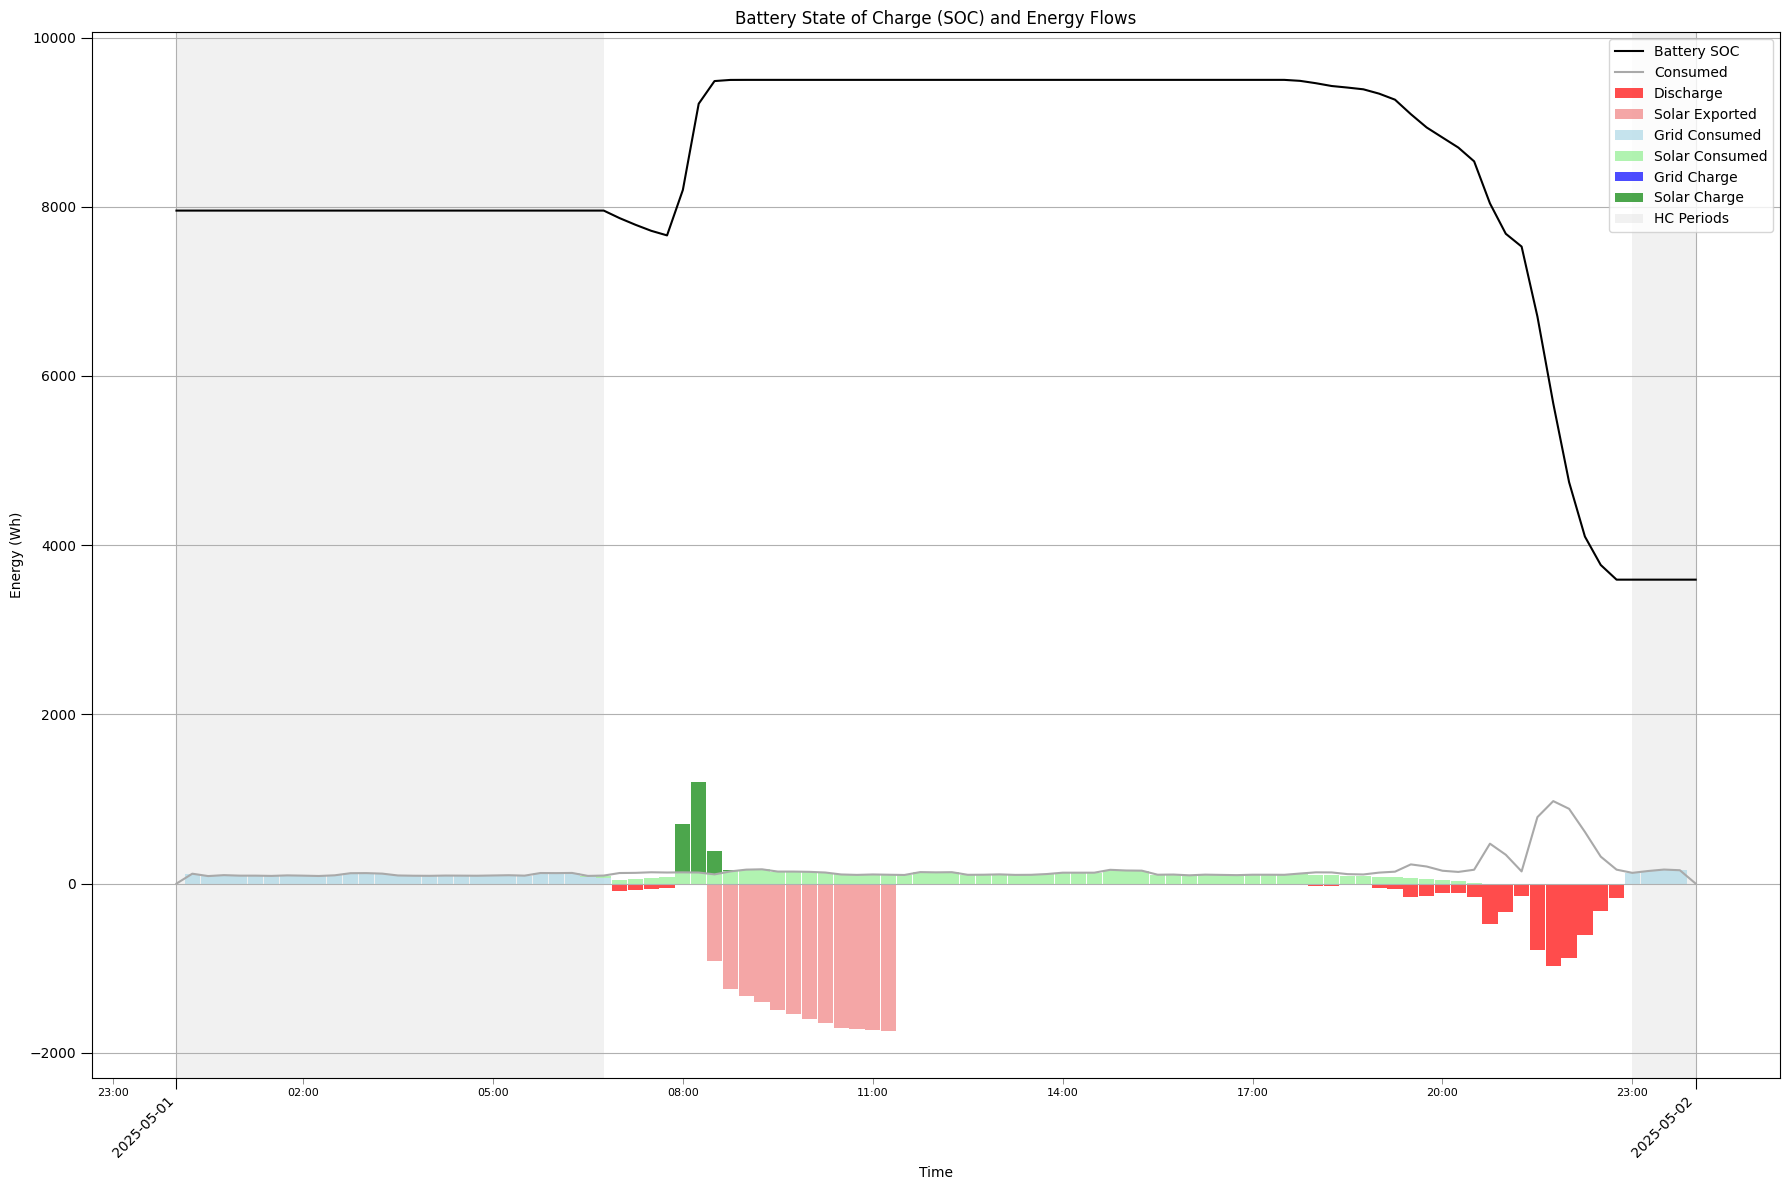

In [146]:
plot_battery_soc(results[-1]['data'], "2025-05-01", "2025-05-02")

#### HC Charging

In [126]:
results = optimize_capacity(
    raw_df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    current_solar_capacity,
    solar_capacities,
    battery_capacities,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    enable_hc_charging=True,
)

--------------------------------------------------------------------
solar       -> 9kWc
battery     -> 50kWh
HC charging -> True

total_cost: 3603 €
total_cost_with_solar: 2125 €
total_cost_with_solar_battery: 2193 €
--------------------------------------------------------------------




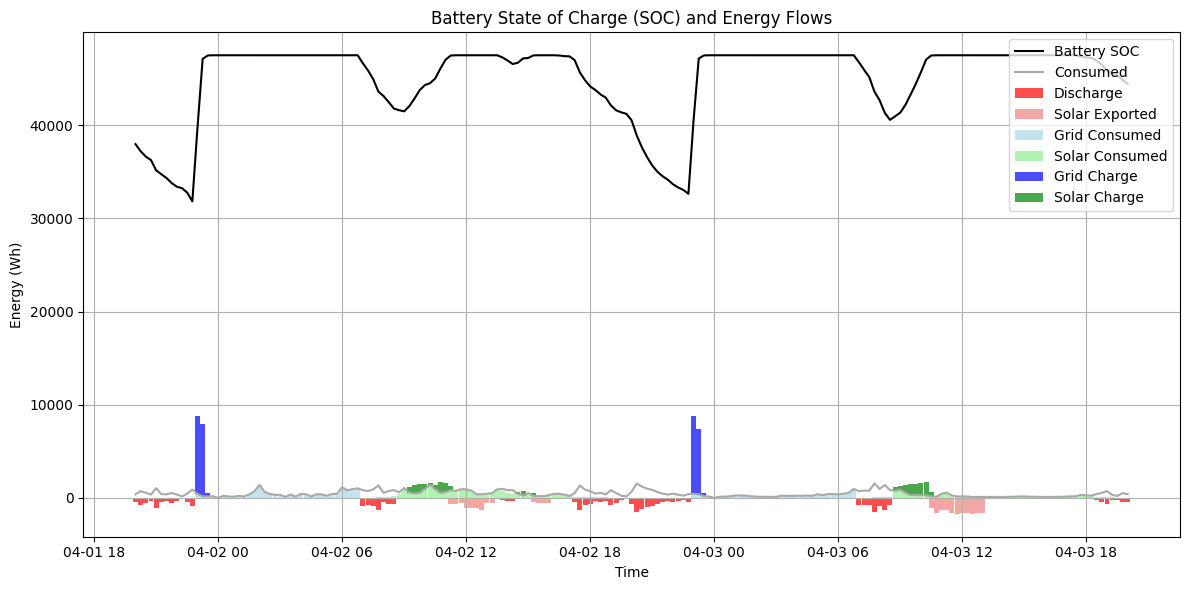

In [127]:
plot_battery_soc(results[-1]['data'], "2025-04-01 20:00:00", "2025-04-03 20:00:00")